# Generate synthetic data from a dynamical system with a known finite-dimensional Koopman operator

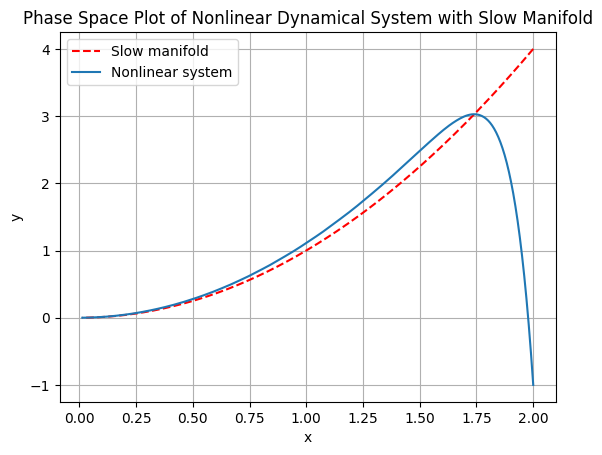

In [1]:
import matplotlib.pyplot as plt

from dynamics import SlowManifold

# define system parameters

mu = -0.05
lam = -1

# create instance of SlowManifold class

system = SlowManifold(mu, lam)

# define initial conditions

x0 = 2.0
y0 = -1.0

# define time span

t_start = 0
t_end = 100
num_points = 1000

# solve the system of differential equations

t, x, y = system.solve(x0, y0, t_start, t_end, num_points)

# plot the results

plt.plot(x, x**2, 'r--', label='Slow manifold')
plt.plot(x, y, label='Nonlinear system')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Phase Space Plot of Nonlinear Dynamical System with Slow Manifold')
plt.legend()
plt.grid(True)
plt.show()

# Prepare data and define DMD data matrices

In [ ]:
import numpy as np
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# concatenate state variables

data = np.stack([x, y]).T
data = data.astype(np.float32)

# define DMD data matrices

X = torch.tensor(data[0:-1,:], device=device)
Y = torch.tensor(data[1:,:], device=device)

N = X.shape[0]


# Define encoder dimensions and create encoder object

In [ ]:
from encoder import Encoder

# define encoder dimensions

input_dim = 2
output_dim = 3
width = 256

# create the encoder network

encoder = Encoder(input_dim, output_dim, width).to(device)

# Perform training

In [ ]:
from loss import ResDMD

# create custom loss function

loss_function = ResDMD()

# create optimizer object

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)

# define number of epochs and perform training

num_epochs = 500

for epoch in range(num_epochs):

    # pass the data through the encoder network

    Ψ_X = encoder(X)
    Ψ_Y = encoder(Y)

    # compute ResDMD matrices

    W = torch.diag((1/N) * torch.ones(N))

    G = torch.conj(torch.transpose(Ψ_X, 0, 1)) @ W @ Ψ_X
    A = torch.conj(torch.transpose(Ψ_X, 0, 1)) @ W @ Ψ_Y
    L = torch.conj(torch.transpose(Ψ_Y, 0, 1)) @ W @ Ψ_Y

    # compute DMD-based estimate of Koopman operator

    K = torch.linalg.pinv(G) @ A

    # compute eigenvalues and eigenvectors of Koopman operator

    λ, g = torch.linalg.eig(K)

    # sort eigenvalues and eigenvectors

    sorted_indices = torch.argsort(λ.real, descending=True)

    λ = λ[sorted_indices]
    g = g[:, sorted_indices]

    # compute the loss

    loss = loss_function(λ, g, G, A, L)

    # perform backpropagation and update the encoder network parameters

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print the loss for tracking progress

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

print("K: " + str(K))
print("Corresponding eigenvalues: " + str(λ))
print("Corresponding eigenvectors: " + str(g))
print("Ψ_X: " + str(Ψ_X[0:10,:]))
print("Ψ_Y: " + str(Ψ_Y[0:10,:]))


# Compute true spectrum using known Koopman operator and lifting dictionary

In [ ]:
# define known Koopman operator

K = [[mu, 0, 0],
    [0, lam, -lam],
    [0, 0, 2*mu]]

K = torch.tensor(K, device=device)

# compute and sort eigenvalues and eigenvectors of known Koopman operator

λ, g = torch.linalg.eig(K)

sorted_indices = torch.argsort(λ.real, descending=True)

λ = λ[sorted_indices]
g = g[:, sorted_indices]

# define known lifting dictionary

Ψ_X = torch.zeros(N,3)
Ψ_X[0:,0] = X[0:,0]; Ψ_X[0:,1] = X[0:,1]; Ψ_X[0:,2] = X[0:,0]**2

Ψ_Y = torch.zeros(N,3)
Ψ_Y[0:,0] = Y[0:,0]; Ψ_Y[0:,1] = Y[0:,1]; Ψ_Y[0:,2] = Y[0:,0]**2

# compute ResDMD matrices

W = torch.diag((1/N) * torch.ones(N))

G = torch.conj(torch.transpose(Ψ_X, 0, 1)) @ W @ Ψ_X
A = torch.conj(torch.transpose(Ψ_X, 0, 1)) @ W @ Ψ_Y
L = torch.conj(torch.transpose(Ψ_Y, 0, 1)) @ W @ Ψ_Y

# compute the loss

loss = loss_function(λ, g, G, A, L)

# derive DMD-based estimate of Koopman operator and compute its eigenvalues and eigenvectors

K_DMD = torch.linalg.pinv(G) @ A

λ_DMD, g_DMD = torch.linalg.eig(K_DMD)

sorted_indices = torch.argsort(λ_DMD.real, descending=True)

λ_DMD = λ_DMD[sorted_indices]
g_DMD = g_DMD[:, sorted_indices]

# compute loss

loss_DMD = loss_function(λ_DMD, g_DMD, G, A, L)

print("True K: " + str(K))
print("Corresponding eigenvalues: " + str(λ))
print("Corresponding eigenvectors: " + str(g))
print("Corresponding loss: " + str(loss))
print("DMD-derived K: " + str(K_DMD))
print("Corresponding eigenvalues: " + str(λ_DMD))
print("Corresponding eigenvectors: " + str(g_DMD))
print("Corresponding loss: " + str(loss_DMD))